## Stardist training example

This notebook shows how to train a Stardist model to predict disks but not rods (remember the rod images have empty labels) 

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [18]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from pathlib import Path
import json

## Check what devices we have access to....

Not as important to have a beefy GPU for 2D as it is for 3D, but let's check

In [19]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is simply because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [20]:
parent_path = r'D:\images\tnia-python-images\imagesc\2025_04_12_disk_like'
n_rays = 32

train_path = os.path.join(parent_path , 'patches')

with open(os.path.join(train_path , 'info.json'), 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = os.path.join(train_path , 'ground truth0')
label_patch_path = os.path.join(train_path , 'input0' )

model_path = os.path.join(parent_path , 'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

sub_sample 1
axes YX


## Use a helper to collect the training data

The helper will also optionally normalize the inputs.  However in this case we set ```normalize_input``` to ```False```.

Normalization is a tricky issue sometimes it makes sense to normalize before creating patches, such that the data is normalized based on statistics of a larger region, closer to the normalization range that will be used for prediction. 

In [21]:
from tnia.deeplearning.dl_helper import collect_training_data
add_trivial_channel = False

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))

100%|██████████| 200/200 [00:02<00:00, 84.46it/s]

type X  <class 'list'>
type Y  <class 'list'>


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK.  We take a look at the 0th (should be a disk image), and the 100th images (should be a rod image), the labels for the rod image should be empty.  

(256, 256) (256, 256)
0.0 0.72591174
0 16
(256, 256) (256, 256)
0.021670146 1.0
0 0


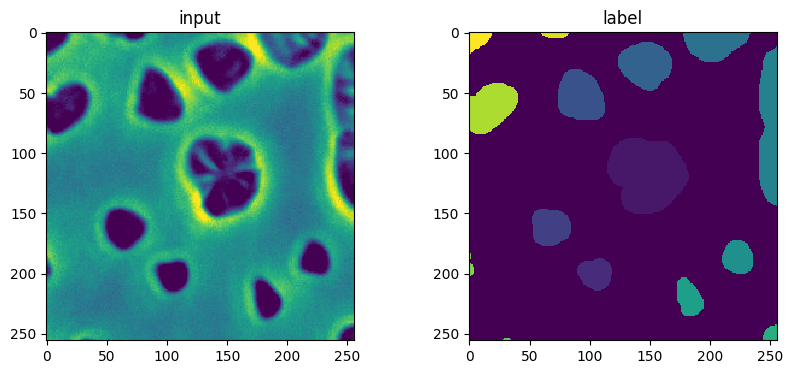

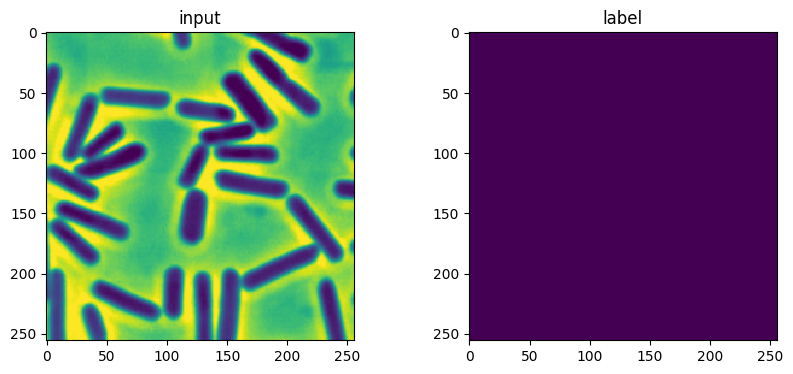

In [22]:
n=77
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
print(Y[n].min(), Y[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

n=177
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
print(Y[n].min(), Y[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

In [9]:
from tnia.deeplearning.dl_helper import divide_training_data
import numpy as np

#X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=2)

X_train = np.array(X)
Y_train = np.array(Y)

X_val = np.array(X[:2])
Y_val = np.array(Y[:2])


print('type X_train ', type(X_train))

type X_train  <class 'numpy.ndarray'>


## Create stardist model

In this cell we create the model.  Make sure to rename the model and give it a descriptive name that conveys the training data and setting used. 

In [10]:
from stardist.models import StarDist2D, Config2D

if axes == 'YXC':
    n_channel_in =3
else:
    n_channel_in = 1

model_name = "stardist_disks"
new_model = True

if new_model:

    config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=3)
    model = StarDist2D(config=config, name=model_name, basedir=model_path)
else:
    model = StarDist2D(config=None, name=model_name, basedir=model_path)

Using default values: prob_thresh=0.5, nms_thresh=0.4.


## Train the model

In [13]:
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=75, steps_per_epoch=100) 

Epoch 1/75
100/100 [==============================] - 31s 196ms/step - loss: 3.0222 - prob_loss: 0.2450 - dist_loss: 13.8858 - prob_kld: 0.1915 - dist_relevant_mae: 13.8846 - dist_relevant_mse: 377.4656 - dist_dist_iou_metric: 0.1386 - val_loss: 2.5601 - val_prob_loss: 0.3040 - val_dist_loss: 11.2803 - val_prob_kld: 0.1984 - val_dist_relevant_mae: 11.2787 - val_dist_relevant_mse: 286.6292 - val_dist_dist_iou_metric: 0.2839 - lr: 3.0000e-04
Epoch 2/75
100/100 [==============================] - 17s 173ms/step - loss: 1.9819 - prob_loss: 0.1758 - dist_loss: 9.0305 - prob_kld: 0.1255 - dist_relevant_mae: 9.0288 - dist_relevant_mse: 190.1107 - dist_dist_iou_metric: 0.3034 - val_loss: 2.2932 - val_prob_loss: 0.2852 - val_dist_loss: 10.0399 - val_prob_kld: 0.1797 - val_dist_relevant_mae: 10.0385 - val_dist_relevant_mse: 246.0228 - val_dist_dist_iou_metric: 0.3232 - lr: 3.0000e-04
Epoch 3/75
100/100 [==============================] - 17s 175ms/step - loss: 1.8391 - prob_loss: 0.1807 - dist_los

In [14]:
model.optimize_thresholds(X_train, Y_train)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:22<00:05,  1.41s/it, 0.497 -> 0.882]


Using optimized values: prob_thresh=0.49523, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.4952300786972046, 'nms': 0.3}

## Test network on some of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

The predictions for the rod images should be empty. 

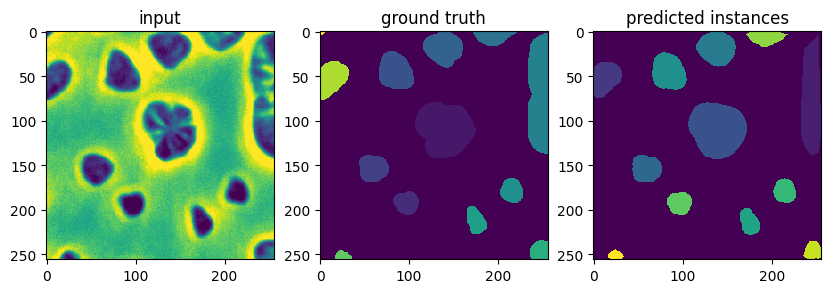

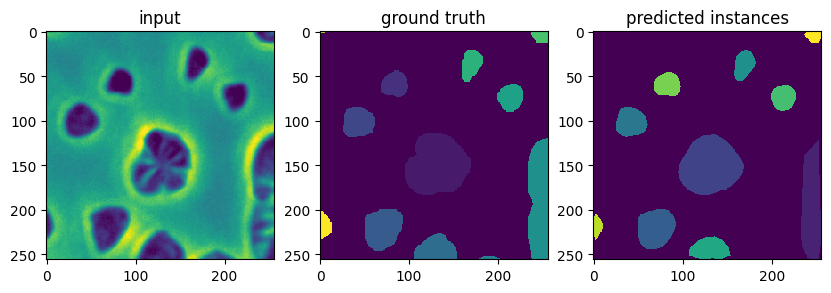

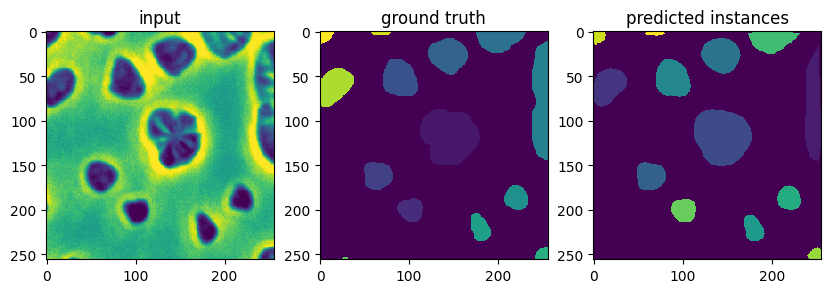

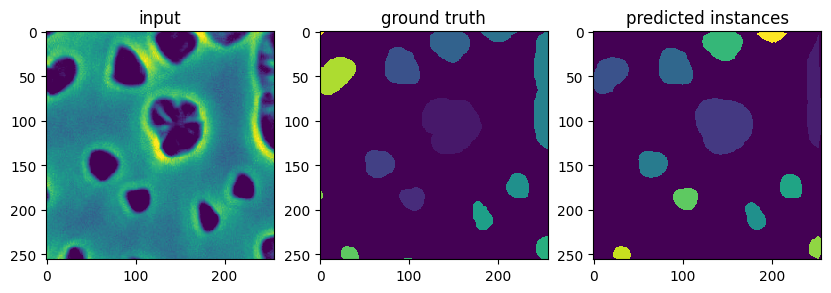

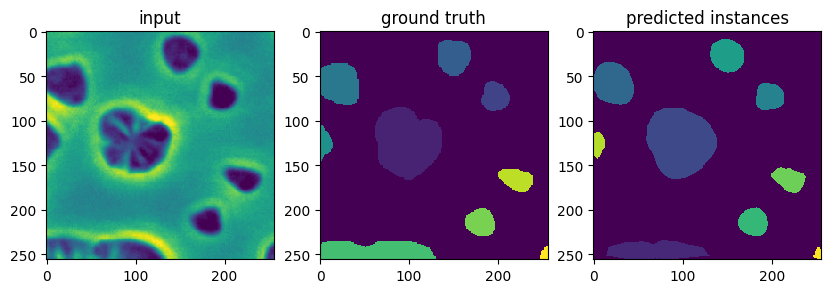

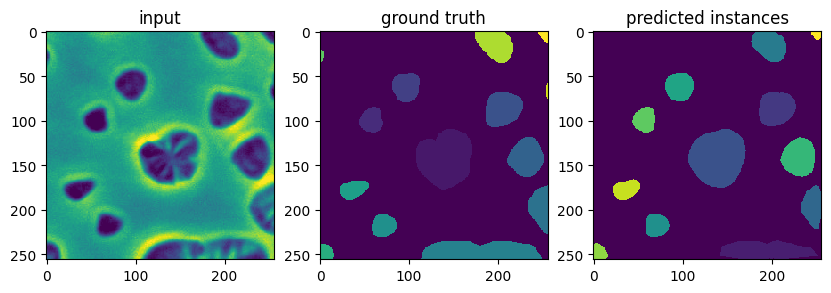

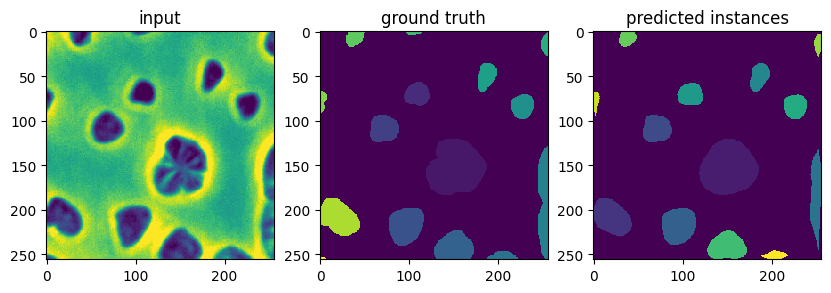

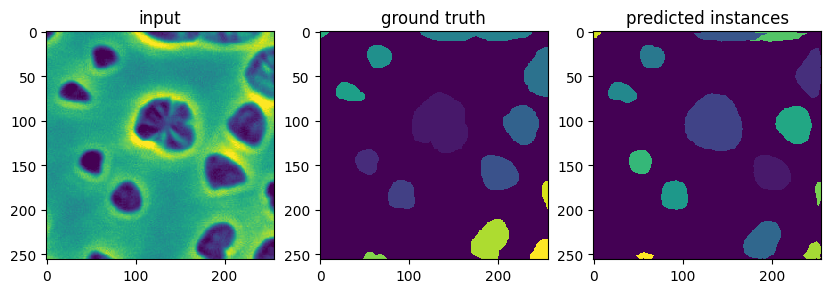

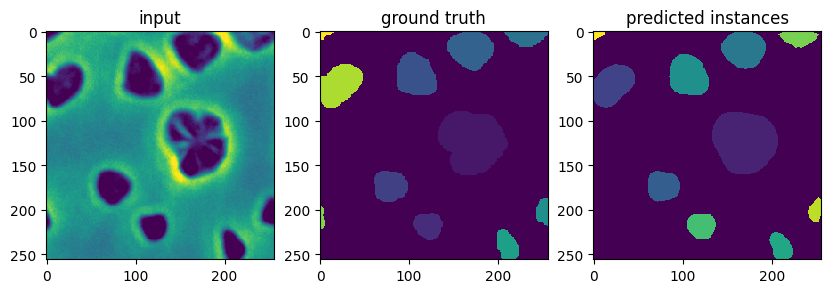

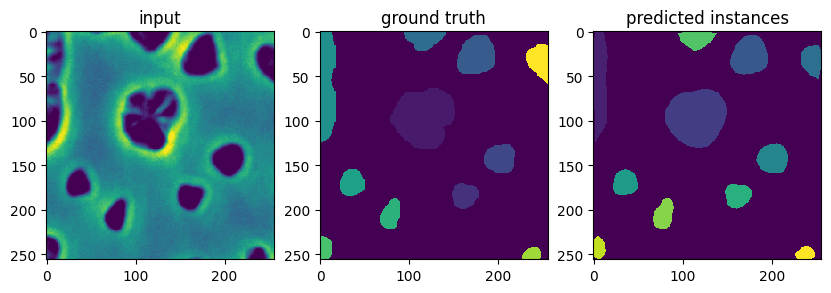

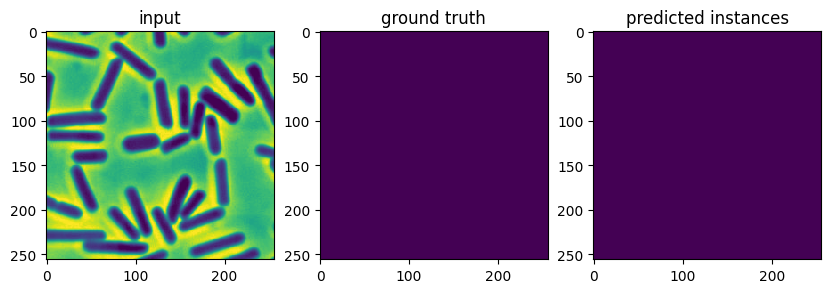

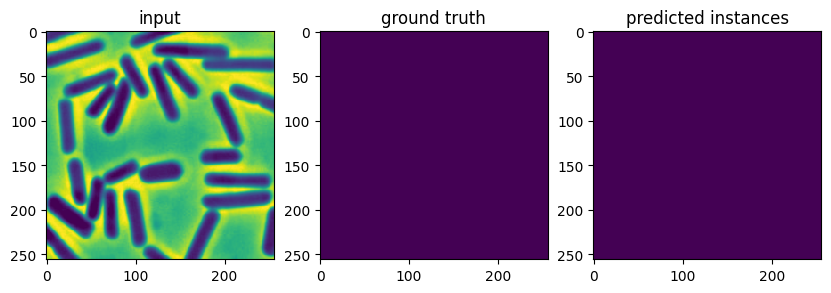

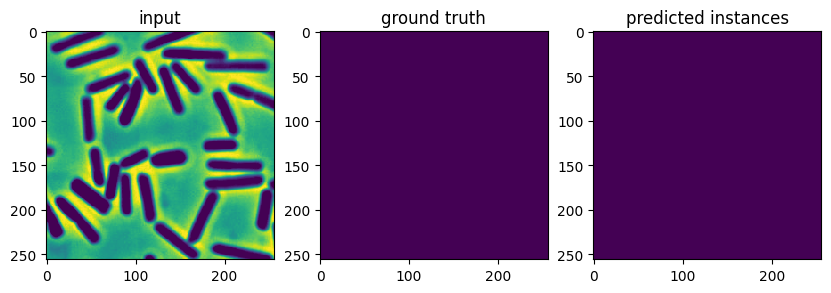

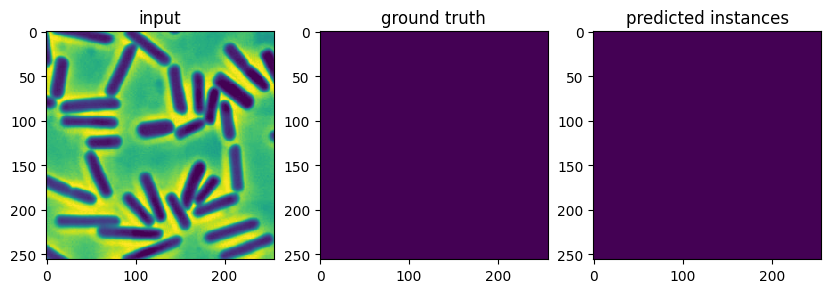

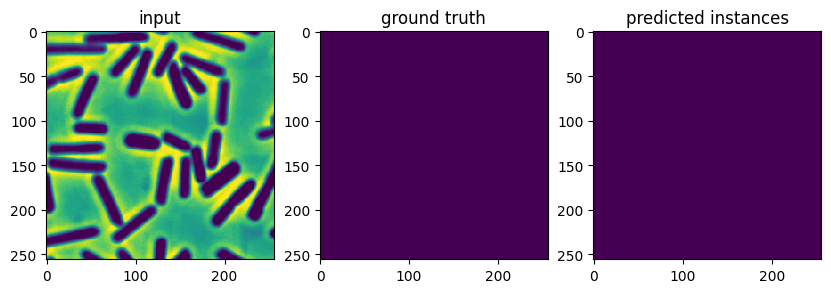

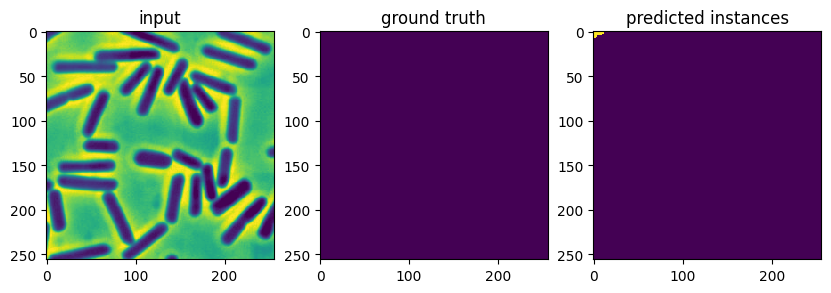

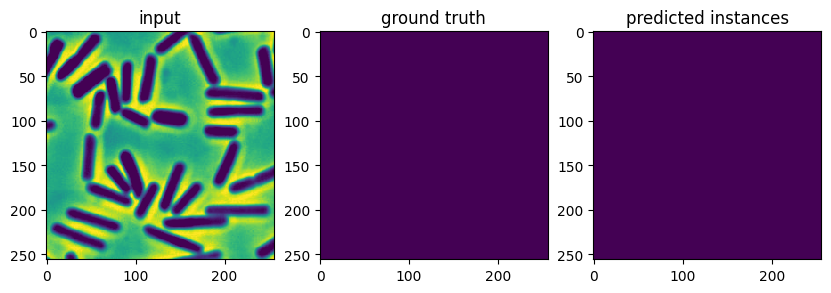

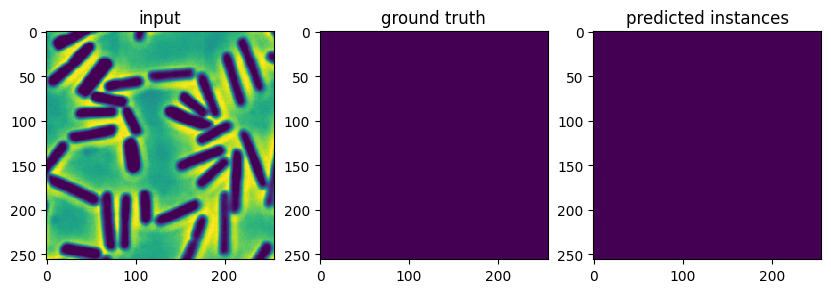

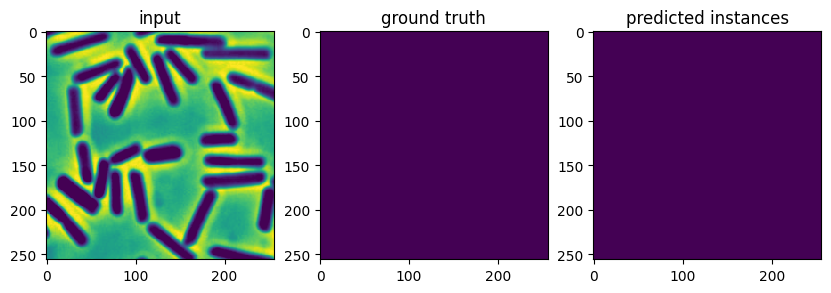

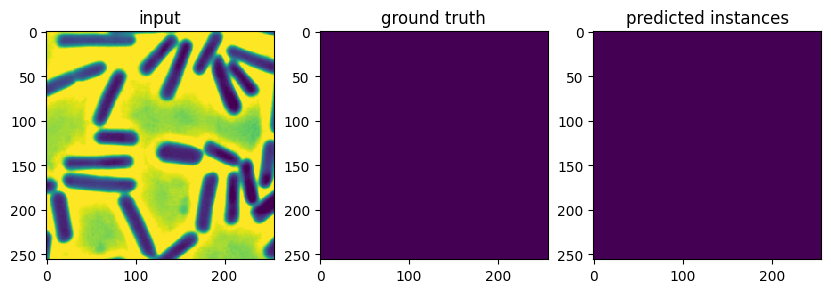

In [16]:
for n in range(10):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.3)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)

for n in range(110,120):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.3)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)

